In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from models.unet import UNet
from tqdm import tqdm
from torchsummary import summary
import numpy as np
from PIL import Image

<class 'torch.device'>
Files already downloaded and verified
Files already downloaded and verified


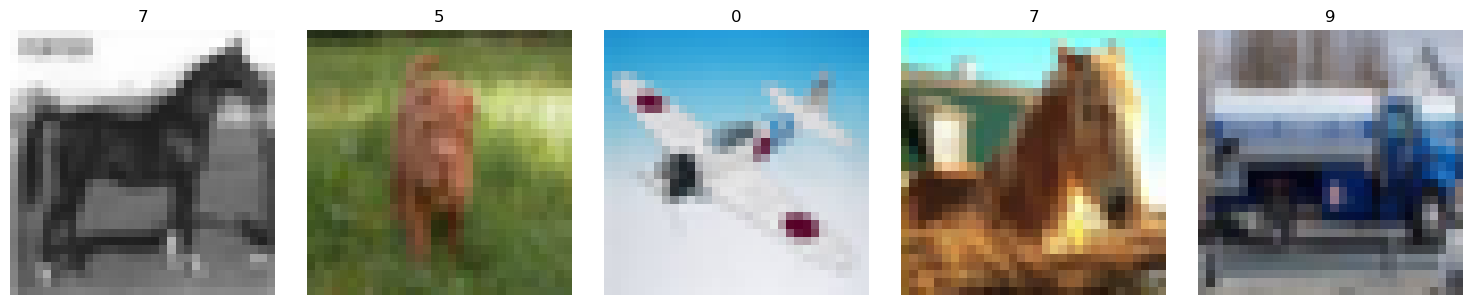

In [2]:
batch_size = 256
print(torch.device)
cifar10_train = datasets.CIFAR10(root='./data', train = True, download = True, transform = transforms.Compose([transforms.ToTensor()]))
cifar10_test = datasets.CIFAR10(root='/.data', train = False, download = True, transform = transforms.Compose([transforms.ToTensor()]))

train_loader_pytorch = torch.utils.data.DataLoader(dataset=cifar10_train, batch_size=batch_size, shuffle=True)
test_loader_pytorch = torch.utils.data.DataLoader(dataset = cifar10_test, batch_size = batch_size, shuffle = False)


def sample_batch(train_data, batch_size = 64, device = 'cuda'):
    # Get a batch of data

    data_iter = iter(train_data)
    images, labels = next(data_iter)

    # Normalize and resize the images
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.Normalize((0.5,), (0.5,))
    ])

    # Apply the transformation to each image
    images = torch.stack([transform(image) for image in images])

    # Move the data to the specified device
    images = images.to(device)
    numpy_images = [image.cpu().numpy() for image in images]

    return images




plt.figure(figsize=(15, 3))

for i, (images, labels) in enumerate(train_loader_pytorch):
    if i < 5:
        plt.subplot(1, 5, i + 1)
        # Convert the image tensor to a NumPy array and transpose dimensions
        img = images[0].permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title(labels[0].item())
        plt.axis('off')
    else:
        break

plt.tight_layout()

In [4]:
class DiffusionModel():

    def __init__(self, T: int, model: nn.Module, device: str):
        self.T = T
        self.function_approximator = model.to(device)
        self.device = device

        self.beta = torch.linspace(1e-4, 0.02, T).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)

    def training(self, batch_size, optimizer):
        """
        Algorithm 1 in Denoising Diffusion Probabilistic Models
        """

        x0 = sample_batch(train_loader_pytorch, batch_size, self.device)

        t = torch.randint(1, self.T + 1, (batch_size,), device=self.device, dtype=torch.long)

        eps = torch.randn_like(x0)



        # Take one gradient descent step
        alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

        eps_predicted = self.function_approximator(torch.sqrt(
            alpha_bar_t) * x0 + torch.sqrt(1 - alpha_bar_t) * eps, t - 1)

        loss = nn.functional.mse_loss(eps, eps_predicted)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def sampling(self, n_samples=1, image_channels=3, img_size=(32, 32), use_tqdm=False):
        x = torch.randn((n_samples, image_channels, img_size[0], img_size[1]),
                        device=self.device)


        for t in range(self.T, 0, -1):
            z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

            t = torch.ones(n_samples, dtype=torch.long, device=self.device) * t

            beta_t = self.beta[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_t = self.alpha[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
            alpha_bar_t = self.alpha_bar[t - 1].unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)

            mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(
                1 - alpha_bar_t)) * self.function_approximator(x, t - 1))
            sigma = torch.sqrt(beta_t)
            x = mean + sigma * z

        return x


device = 'cuda'


model = UNet()


optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

diffusion_model = DiffusionModel(1000, model, device)
training_loss = []

for epoch in tqdm(range(40_001)):
    loss = diffusion_model.training(batch_size, optimizer)
    training_loss.append(loss)

    # if epoch % 1000 == 0:
    #     plt.plot(training_loss)
    #     plt.savefig('training_loss.png')
    #     plt.close()
    #
    #     plt.plot(training_loss[-1000:])
    #     plt.savefig('training_loss_cropped.png')
    #     plt.close()

    if epoch % 5000 == 0:
        nb_images = 64
        samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=False)
        plt.figure(figsize=(10, 10))
        for i in range(nb_images):
            plt.subplot(8, 8, 1 + i)
            plt.axis('off')
            plt.imshow(samples[i].permute(1, 2, 0).clip(0, 1).data.cpu().numpy())
        plt.savefig(f'figs/samples_epoch_{epoch}.png')
        plt.close()

        torch.save(model.cpu(), f'weights/unet_denoiser_{epoch}')
        model.cuda()

# samples = diffusion_model.sampling(n_samples=nb_images, use_tqdm=True)
# plt.figure(figsize=(17, 17))
# for i in range(nb_images):
#     plt.subplot(9, 9, 1 + i)
#     plt.axis('off')
#     plt.imshow(samples[i].squeeze(0).clip(0, 1).data.cpu().numpy(), cmap='gray')
# plt.savefig(f'samples_epoch_{epoch}.png')
# plt.close()

torch.save(model.cpu(), f'weights/diffusion_cifar10_{epoch}')


100%|██████████| 40001/40001 [3:37:49<00:00,  3.06it/s]    
